In [1]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import PowerTransformer, StandardScaler
from IPython.core.debugger import set_trace

## a)

In [2]:
df_predictors = pd.read_csv('../Data/permeability_predictors.csv')
df_response = pd.read_csv('../Data/permeability_response.csv')

In [3]:
df_predictors

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1014,X1015,X1016,X1017,X1018,X1019,X1020,X1021,X1022,X1023
0,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
161,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
162,1,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
163,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_response

,permeability
0,12.520
1,1.120
2,19.405
3,1.730
4,1.680
...,...
160,0.705
161,0.525
162,1.545
163,39.555


## b)

In [5]:
def find_near_and_zero_var(df: pd.DataFrame, fraction_threshold=0.1, ratio_threshold=20):
    near_zero_cols = []
    zero_cols = []
    sample_size = df.shape[0]
    #set_trace()
    for column in df.columns.values:
        low_fraction = False
        large_ratio = False
        num_occurances = df[column].value_counts().nlargest(n=2)
        # Zero variance
        if num_occurances.size < 2:
            zero_cols.append(column)
        # Near zero variance
        else:
            if num_occurances.iloc[0] / num_occurances.iloc[1] >= ratio_threshold:
                large_ratio = True
            unique_vals = pd.unique(df[column])
            if unique_vals.size / sample_size <= fraction_threshold:
                low_fraction = True
            if low_fraction and large_ratio:
                near_zero_cols.append(column)
    return np.array(zero_cols), np.array(near_zero_cols)

In [8]:
zero_var_cols, near_zero_var_cols = find_near_and_zero_var(df=df_predictors)
print(f'Zero var cols = {zero_var_cols.size}\nNear-zero var cols = {near_zero_var_cols.size}')

Zero var cols = 38
Near-zero var cols = 572


## c)

In [9]:
df_predictors_reduced = df_predictors.drop(columns=np.concatenate((zero_var_cols, near_zero_var_cols)))
df_predictors_dummy = pd.get_dummies(df_predictors_reduced, drop_first=True)  # Redudnant in this particular case.
X_train, X_test, Y_train, Y_test = train_test_split(df_predictors_reduced, df_response)

In [10]:
def score_model(model, X, Y):
    predictions = model.predict(X)
    return r2_score(y_true=Y, y_pred=predictions), np.sqrt(mean_squared_error(y_true=Y, y_pred=predictions))

def print_score(model_name, parameter_name, parameter_values, rmses, r2s):
    rmse_best_idx = rmses.argmin()
    rmse_best_value = rmses[rmse_best_idx]
    r2_best_idx = r2s.argmax()
    r2_best_value = r2s[r2_best_idx]
    print(f'{model_name} acheives the optimal result for {parameter_name} = {parameter_values[rmse_best_idx]} with \n'
          f'RMSE = {rmse_best_value}\n'
          f'R-Squared = {r2_best_value}')

def plot_r2_rmse(r2s, rmses, x_label, x_vals):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.plot(x_vals, r2s)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('R^2')
    ax2.plot(x_vals, rmses)
    ax2.set_xlabel(x_label)
    ax2.set_ylabel('RMSE');

In [11]:
def do_pls(X_train, X_test, Y_train, Y_test, max_components):
    chosen_components = np.arange(1, max_components + 1)
    r2s = np.empty(max_components)
    rmses = np.empty(max_components)
    #set_trace()
    for i in chosen_components:
        model = PLSRegression(n_components=i)
        model.fit(X_train, Y_train)
        r2s[i - 1], rmses[i - 1] = score_model(model, X_test, Y_test)

    plot_r2_rmse(r2s=r2s, rmses=rmses, x_label='Number of components', x_vals=chosen_components)
    print_score(model_name='PLSR', parameter_name='number of components', parameter_values=chosen_components,
                rmses=rmses, r2s=r2s)

def do_ridge(X_train, X_test, Y_train, Y_test, alpha_min, alpha_max):
    alphas = np.linspace(alpha_min, alpha_max, 50)
    r2s_ridge = np.empty(alphas.size)
    rmses_ridge = np.empty(alphas.size)
    for i, alpha in enumerate(alphas):
        model = Ridge(alpha=alpha)
        model.fit(X_train, Y_train)
        r2s_ridge[i], rmses_ridge[i] = score_model(model, X_test, Y_test)

    plot_r2_rmse(r2s=r2s_ridge, rmses=rmses_ridge, x_label='Alpha', x_vals=alphas)
    print_score(model_name='Ridge', parameter_name='alpha', parameter_values=alphas, rmses=rmses_ridge, r2s=r2s_ridge)

def do_lasso(X_train, X_test, Y_train, Y_test, alpha_min, alpha_max):
    alphas = np.linspace(alpha_min, alpha_max, 50)
    r2s_lasso = np.empty(alphas.size)
    rmses_lasso = np.empty(alphas.size)
    for i, alpha in enumerate(alphas):
        model = Lasso(alpha=alpha)
        model.fit(X_train, Y_train)
        r2s_lasso[i], rmses_lasso[i] = score_model(model, X_test, Y_test)

    plot_r2_rmse(r2s=r2s_lasso, rmses=rmses_lasso, x_label='Alpha', x_vals=alphas)
    print_score(model_name='Lasso', parameter_name='alpha', parameter_values=alphas, rmses=rmses_lasso, r2s=r2s_lasso)

def do_elastic_net(X_train, X_test, Y_train, Y_test, alpha_min, alpha_max):
    alphas = np.linspace(alpha_min, alpha_max, 50)
    r2s_elastic = np.empty(alphas.size)
    rmses_elastic = np.empty(alphas.size)
    for i, alpha in enumerate(alphas):
        model = ElasticNet(alpha=alpha)
        model.fit(X_train, Y_train)
        r2s_elastic[i], rmses_elastic[i] = score_model(model, X_test, Y_test)

    plot_r2_rmse(r2s=r2s_elastic, rmses=rmses_elastic, x_label='Alpha', x_vals=alphas)
    print_score(model_name='ElasticNet', parameter_name='alpha', parameter_values=alphas, rmses=rmses_elastic,
                r2s=r2s_elastic)

## PLSR

PLSR acheives the optimal result for number of components = 30 with 
RMSE = 3.691360758862116
R-Squared = 0.9461470628403238


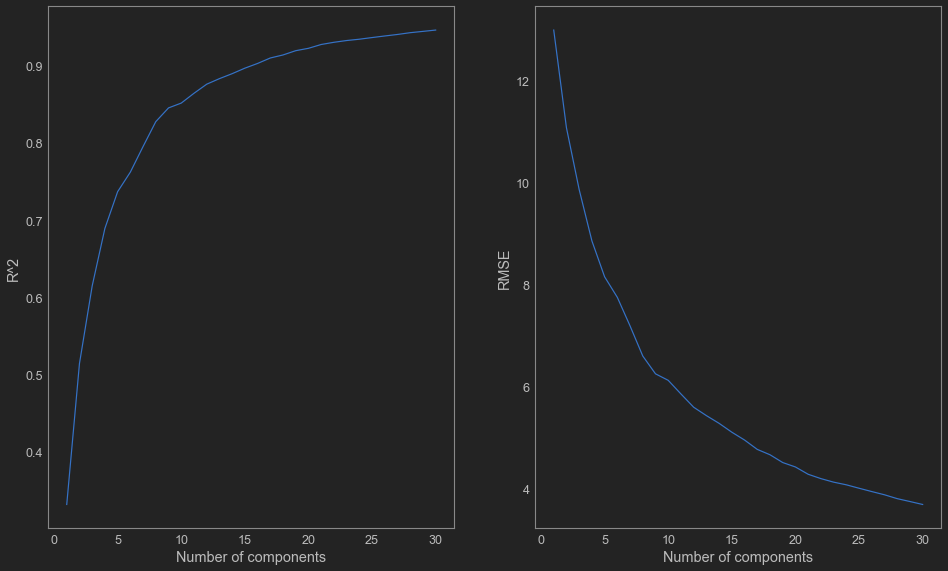

In [12]:
# Validating the model with resampled train set.
do_pls(X_train, X_train, Y_train, Y_train, max_components=30)

## d)

PLSR acheives the optimal result for number of components = 2 with 
RMSE = 11.260324529655648
R-Squared = 0.3762572978143115


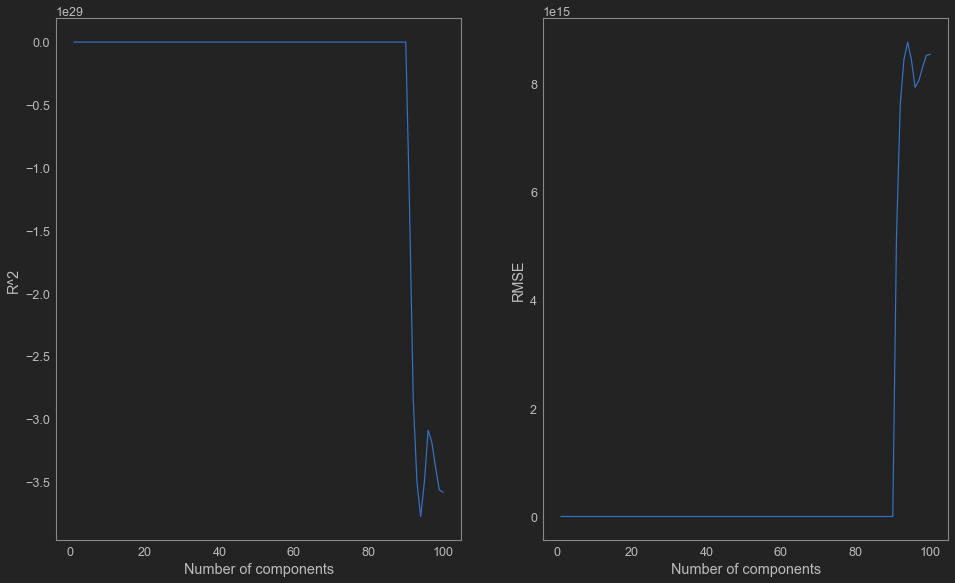

In [13]:
# Valiating model with test set.
do_pls(X_train, X_test, Y_train, Y_test, max_components=100)

## e)

## Ridge

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Ridge acheives the optimal result for alpha = 4.0816326530612245e-05 with 
RMSE = 2.928866595251565
R-Squared = 0.9660971979297709


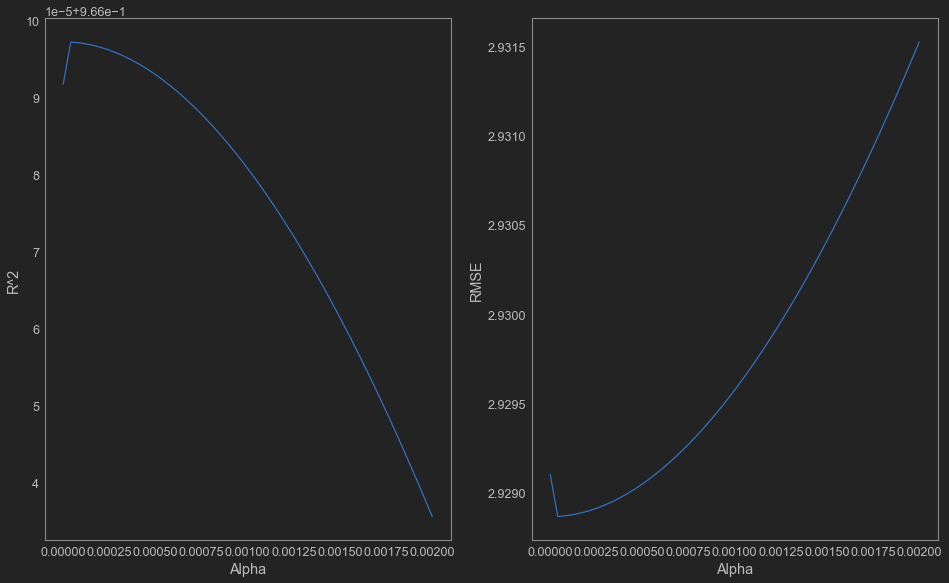

In [14]:
do_ridge(X_train, X_train, Y_train, Y_train, alpha_min=0.0, alpha_max=0.002)

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Ridge acheives the optimal result for alpha = 28.571428571428573 with 
RMSE = 10.911046116888782
R-Squared = 0.4143522953481319


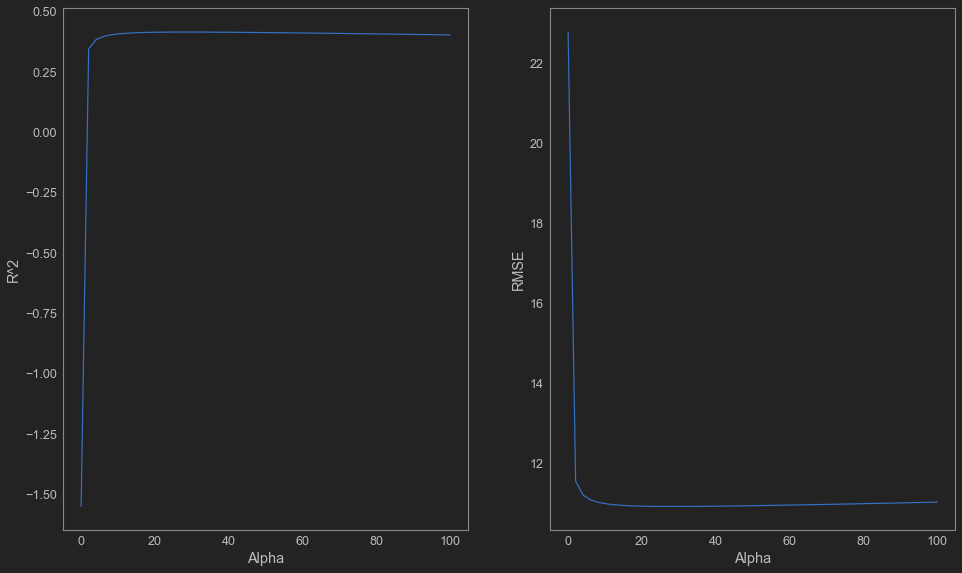

In [15]:
do_ridge(X_train, X_test, Y_train, Y_test, alpha_min=0.0, alpha_max=100)

## Lasso

<ipython-input-11-ee10740feaad>:33: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train, Y_train)
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 541.3781649985041, tolerance: 3.112208602540651
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 491.528307939983, t

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.36523148425113, tolerance: 3.112208602540651
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142.25235633409375, tolerance: 3.112208602540651
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125.1216126951922, tolerance: 3.112208602540651
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packa

Lasso acheives the optimal result for alpha = 0.0 with 
RMSE = 2.966967642534302
R-Squared = 0.9652093908771702


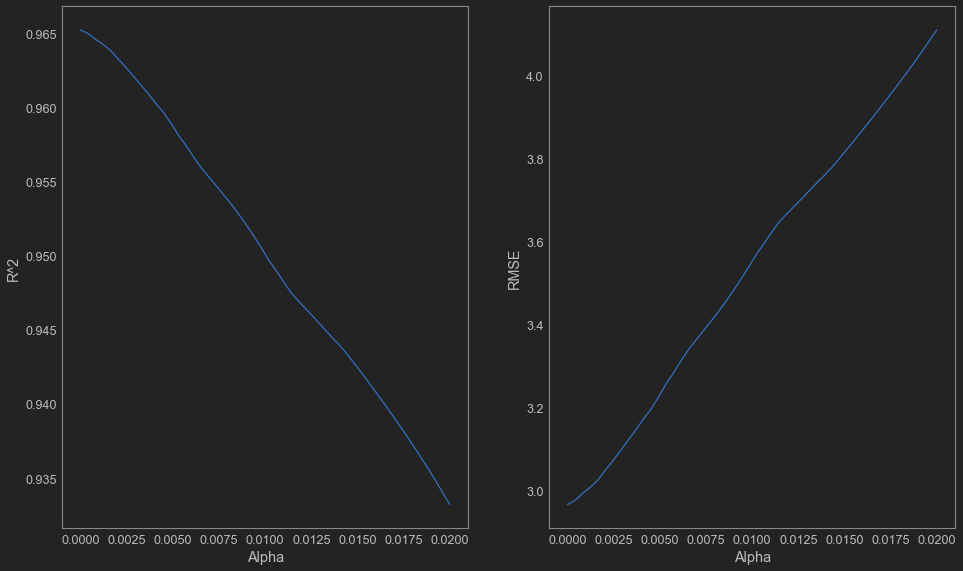

In [16]:
do_lasso(X_train, X_train, Y_train, Y_train, alpha_min=0, alpha_max=0.02)

Lasso acheives the optimal result for alpha = 0.8693877551020408 with 
RMSE = 10.43081498853146
R-Squared = 0.46477037026819656


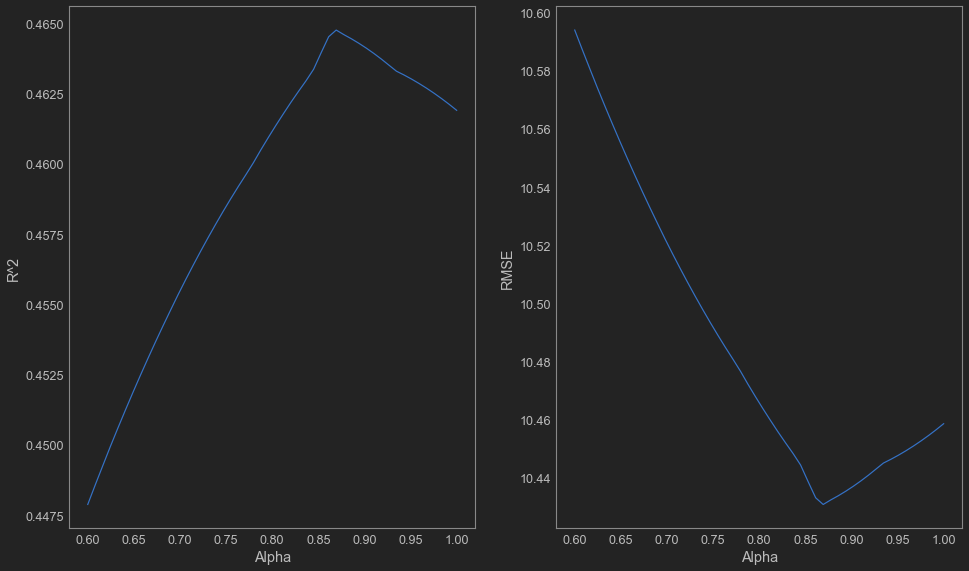

In [17]:
do_lasso(X_train, X_test, Y_train, Y_test, alpha_min=0.6, alpha_max=1.0)

## ElasticNet

<ipython-input-11-ee10740feaad>:45: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train, Y_train)
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 541.3781649985041, tolerance: 3.112208602540651
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.8853758221355, 

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.660079736759, tolerance: 3.112208602540651
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 592.1960740391887, tolerance: 3.112208602540651
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 593.7189491812456, tolerance: 3.112208602540651
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages

ElasticNet acheives the optimal result for alpha = 0.0 with 
RMSE = 2.966967642534302
R-Squared = 0.9652093908771702


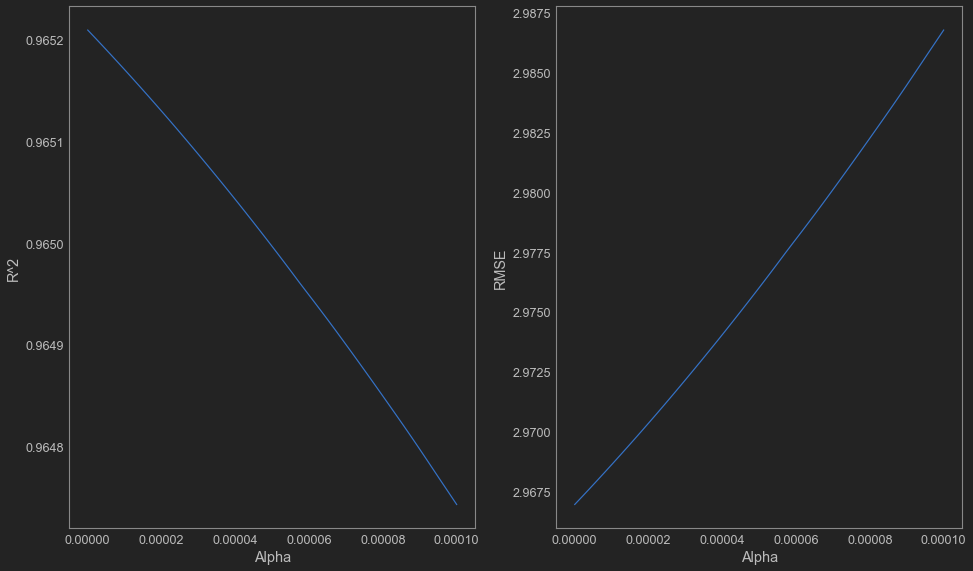

In [18]:
do_elastic_net(X_train, X_train, Y_train, Y_train, alpha_min=0, alpha_max=0.0001)

<ipython-input-11-ee10740feaad>:45: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train, Y_train)
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 541.3781649985041, tolerance: 3.112208602540651
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.82773082002177, 

ElasticNet acheives the optimal result for alpha = 0.2857142857142857 with 
RMSE = 10.63379935198939
R-Squared = 0.4437364724833517


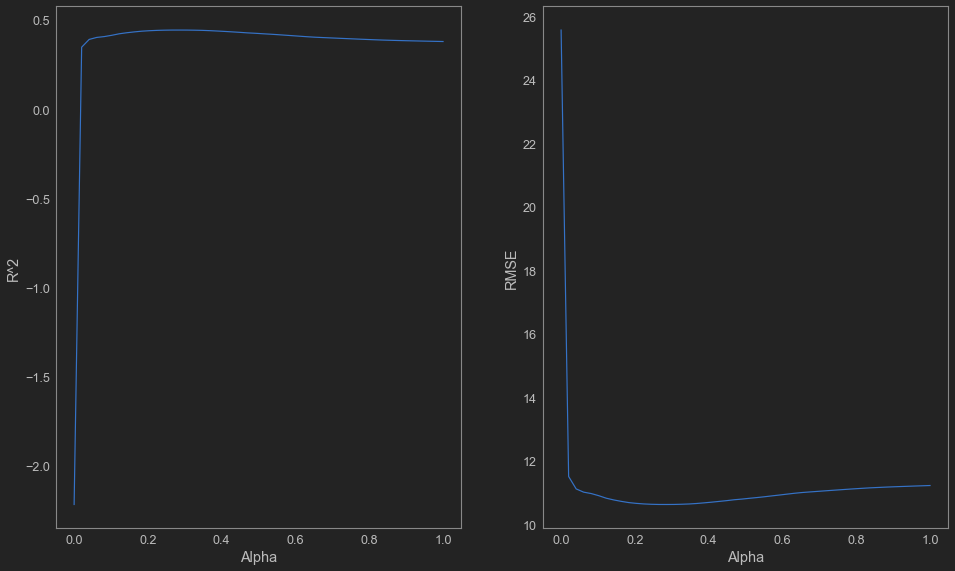

In [19]:
do_elastic_net(X_train, X_test, Y_train, Y_test, alpha_min=0, alpha_max=1)

In [20]:
df_response.describe()

,permeability
count,165.000000
mean,12.237439
std,15.578654
min,0.060000
25%,1.550000
50%,4.910000
75%,15.470000
max,55.600000
